# Constructing the Sensitivity Matrix
*David Thomas 2019/07/01*

**Abstract:** We compute the sensitivity matrix which maps the optical state, represented with 20 degrees of freedom, to the annular zernike terms in the corresponding wavefront.

**Table of Contents:**
- [Recovering Annular Zernike Coefficients](#Recovering-Annular-Zernike-Coefficients)
- [Defining The Degrees Of Freedom](#Defining-The-Degrees-Of-Freedom)
- [Defining The Optical Path Difference](#Defining-the-Optical-Path-Difference)
- [Computing The Sensitivity Matrix For The Field Center](#Computing-The-Sensitivity-Matrix-For-The-Field-Center)

## Recovering Annular Zernike Coefficients

In this section we define and validate the function we will use to fit OPDs (optical path differences).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import batoid
import yaml
from batoid.utils import fieldToDirCos
import galsim

In [2]:
def fitOPD(opdArray, nZern=22, obscuration=0.61):
    nx = opdArray.shape[0]
    X, Y = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
    R = np.sqrt(X ** 2 + Y ** 2)
    mask = np.logical_and(R <= 1, R >= obscuration)
    basis = galsim.zernike.zernikeBasis(nZern, X[mask].flatten(), Y[mask].flatten(),
                         R_inner=obscuration)
    coefs, _, _, _ = np.linalg.lstsq(basis.T, opdArray[mask].flatten())
    return coefs[1:]
    
def makeZernike(ind, nx=256, obscuration=0.61):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
    R = np.sqrt(X ** 2 + Y ** 2)
    mask = np.logical_and(R <= 1, R >= obscuration)
    zernikes = np.zeros(ind+1)
    zernikes[ind] = 1
    zern = galsim.zernike.Zernike(zernikes, R_inner=obscuration)
    Z = zern.evalCartesian(X,Y)
    Z[~mask] = np.nan
    return Z, mask

In [3]:
nx = 32
obscuration = 0.61
nZern = 22
X, Y = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.logical_and(R <= 1, R >= obscuration)
basis = galsim.zernike.zernikeBasis(nZern, X[mask].flatten(), Y[mask].flatten(),
                     R_inner=obscuration)

In [4]:
def testMakeZernike():
    nZern = 22
    orthonormal = np.zeros((nZern, nZern))
    for i in range(nZern):
        for j in range(nZern):
            Zi, mask = makeZernike(i + 1)
            Zj, _ = makeZernike(j + 1)
            orthonormal[i,j] = np.sum(Zi[mask] * Zj[mask]) / np.sum(mask)
    plt.figure()
    plt.title('Orthonormal')
    plt.imshow(orthonormal, origin='lower')
    plt.colorbar()
    
    plt.figure()
    plt.title('Orthonormal - Identity')
    plt.imshow(orthonormal - np.eye(22), origin='lower')
    plt.colorbar()
    
def testFitOPD():
    nZern = 22
    decomposition = np.zeros((nZern, nZern))
    for i in range(nZern):
        Zi, _ = makeZernike(i + 1)
        decomposition[i,:] = fitOPD(Zi)

    plt.figure()
    plt.title('Decomposition')
    plt.imshow(decomposition, origin='lower')
    plt.colorbar()
    
    plt.figure()
    plt.title('Decomposition - Identity')
    plt.imshow(decomposition - np.eye(22), origin='lower')
    plt.colorbar()

Here we confirm the annular zernike polynomials we use are orthonormal.

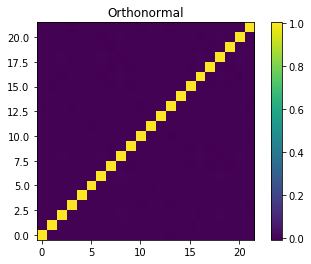

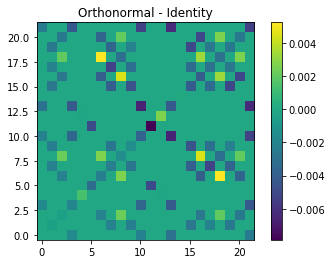

In [5]:
testMakeZernike()

Here we confirm that we can decompose zernike images into their components.

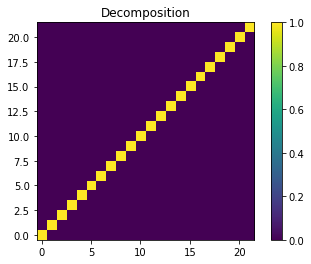

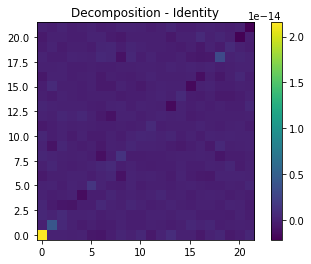

In [6]:
testFitOPD()

## Defining The Degrees Of Freedom

We employ 20 degrees of freedom: 5 translations and rotations for each of the camera and M2, 5 M1M3 bending modes, and 5 M2 bending modes. We store the degrees of freedom and their corresponding batoid optical transformations in the DOF class below. The DOF.stepSize values are the size of the linear step we take to compute the sensitivity for the corresponding degree of freedom. These step sizes come from Bo Xin's original calculation.

In [7]:
from collections import OrderedDict

class DOF:
    arcsecondToRad = (1 / 3600) * (np.pi / 180)
    
    def __init__(self, nbend=20):
        # not member variables because all this data gets stored in closures
        m1m3_x = np.load('../data/M1M3_grid_x.npy')
        m1m3_y = np.load('../data/M1M3_grid_y.npy')
        m1m3_modes = np.load('../data/M1M3_bending_modes.npy')
        m2_x = np.load('../data/M2_grid_x.npy')
        m2_y = np.load('../data/M2_grid_y.npy')
        m2_modes = np.load('../data/M2_bending_modes.npy')
        
        methods = OrderedDict()
        # camera shifts
        methods['camx'] = DOF.shift('LSST.LSSTCamera', np.array([1,0,0]))
        methods['camy'] = DOF.shift('LSST.LSSTCamera', np.array([0,1,0]))
        methods['camz'] = DOF.shift('LSST.LSSTCamera', np.array([0,0,1]))
        # camera rotations
        methods['camrx'] = DOF.rotate('LSST.LSSTCamera', batoid.RotX)
        methods['camry'] = DOF.rotate('LSST.LSSTCamera', batoid.RotY)
        # m2 shifts
        methods['m2x'] = DOF.shift('LSST.M2', np.array([1,0,0]))
        methods['m2y'] = DOF.shift('LSST.M2', np.array([0,1,0]))
        methods['m2z'] = DOF.shift('LSST.M2', np.array([0,0,1]))
        # m2 rotations
        methods['m2rx'] = DOF.rotate('LSST.M2', batoid.RotX)
        methods['m2ry'] = DOF.rotate('LSST.M2', batoid.RotY)
        # m1m3 bending modes
        for i in range(nbend):
            methods['m1m3b{}'.format(i)] = DOF.m1m3Bending(m1m3_x, m1m3_y, m1m3_modes[i])
        # m2 bending modes
        for i in range(nbend):
            methods['m2b{}'.format(i)] = DOF.m2Bending(m2_x, m2_y, m2_modes[i])

        self.methods = methods
        self.stepSize = {
            'camx': 500e-6,
            'camy': 500e-6,
            'camz': 100e-6,
            'camrx': 60 * DOF.arcsecondToRad,
            'camry': 60 * DOF.arcsecondToRad,
            'm2x': 500e-6,
            'm2y': 500e-6,
            'm2z': 100e-6,
            'm2rx': 40 * DOF.arcsecondToRad,
            'm2ry': 40 * DOF.arcsecondToRad,
        }
        for i in range(nbend):
            self.stepSize['m1m3b{}'.format(i)] = 500e-9
            self.stepSize['m2b{}'.format(i)] = 200e-9
    
    @staticmethod
    def shift(name, direction):
        def apply(telescope, scale):
            return telescope.withGloballyShiftedOptic(name, direction * scale)
        return apply
    
    @staticmethod
    def rotate(name, rotFunc):
        def apply(telescope, rad):
            return telescope.withLocallyRotatedOptic(name, rotFunc(rad))
        return apply
    
    @staticmethod
    def m1m3Bending(x,y,mode):
        def apply(telescope, scale):
            zs = mode * scale
            pert = batoid.Bicubic(x, y, zs)
            m1surf = telescope.itemDict['LSST.M1'].surface
            m3surf = telescope.itemDict['LSST.M3'].surface
            telescope.itemDict['LSST.M1'].surface = batoid.Sum([m1surf, pert])
            telescope.itemDict['LSST.M3'].surface = batoid.Sum([m3surf, pert])
            return telescope
        return apply
    
    @staticmethod
    def m2Bending(x,y,mode):
        def apply(telescope, scale):
            zs = mode * scale
            pert = batoid.Bicubic(x, y, zs)
            m2surf = telescope.itemDict['LSST.M2'].surface
            telescope.itemDict['LSST.M2'].surface = batoid.Sum([m2surf, pert])
            return telescope
        return apply

## Defining The Optical Path Difference

In this section we lay out the optical path difference (OPD) computation. This calculations makes a 256x256 grid of rays at the entrance pupil and measures the distance they travel to the exit pupil. The difference between these path differences and the path difference of the chief ray is the wavefront. We use the diction optical path difference (OPD) to refer to the true wavefront.

Special thanks to Josh Meyers for providing this snippet.

In [8]:
def opd(optic, theta_x=0, theta_y=0, wavelength=500e-9, nx=256, flux=1):
    projection='zemax'
    dirCos = fieldToDirCos(theta_x, theta_y, projection=projection)
    rays = batoid.rayGrid(
        optic.dist/dirCos[2], optic.pupilSize,
        dirCos[0], dirCos[1], -dirCos[2],
        nx, wavelength, flux, optic.inMedium, lattice=True)
    
    # chief ray index.  works if lattice=True and nx is even,
    # or if lattice=False and nx is odd
    cridx = (nx//2)*nx+nx//2
    
    optic.traceInPlace(rays, outCoordSys=batoid.globalCoordSys)
    spherePoint = rays[cridx].r
    
    # We want to place the vertex of the reference sphere one radius length away from the
    # intersection point.  So transform our rays into that coordinate system.
    radius = np.hypot(optic.sphereRadius, np.hypot(spherePoint[0], spherePoint[1]))
    transform = batoid.CoordTransform(
            batoid.globalCoordSys, batoid.CoordSys(spherePoint+np.array([0,0,radius])))
    transform.applyForwardInPlace(rays)

    sphere = batoid.Sphere(-radius)
    sphere.intersectInPlace(rays) 
    t0 = rays[cridx].t
    arr = np.ma.masked_array(t0-rays.t, mask=rays.vignetted).reshape(nx, nx)

    primitiveVectors = np.vstack([[optic.pupilSize/nx, 0], [0, optic.pupilSize/nx]])
    return batoid.Lattice(arr, primitiveVectors)

## Computing The Sensitivity Matrix For The Field Center

We assume that small disturbances around the nominal optical state lead to a linear response in the wavefront. This is prescribed by the relation $y-y_0 = Ax$, where $y,y_0 \in R^{22}$ are the wavefront and nominal wavefront; $A \in R^{22,20}$ is the sensitivity matrix; and $x\in R^{20}$ is the optical state.

In [9]:
def newTelescope():
    LSST_g_fn = os.path.join(batoid.datadir, "LSST", "LSST_g.yaml")
    config = yaml.safe_load(open(LSST_g_fn))
    return batoid.parse.parse_optic(config['opticalSystem'])

In [10]:
def makeSensitivityMatrix(dxScale=1):
    nbend = 5
    totdof = 5 + 5 + 2 * nbend 
    # 5 for each of camera hexapod, m2 hexapod, plus 2 sets of bending modes
    y0 = fitOPD(opd(newTelescope()).array)
    dof = DOF(nbend=nbend)
    A = np.zeros((22, totdof))
    i = 0
    for k,func in dof.methods.items():
        dx = dof.stepSize[k] * dxScale
        tel1 = newTelescope()
        tel2 = newTelescope()
        opd1 = opd(func(tel1, -dx))
        opd2 = opd(func(tel2, dx))
        z1 = fitOPD(opd1.array)
        z2 = fitOPD(opd2.array)
        A[:,i] = (z2 - z1) / (2 * dx)
        i += 1
    return A, y0

In [11]:
A, y0 = makeSensitivityMatrix(dxScale=1)
Ascaled, y0scaled = makeSensitivityMatrix(dxScale=0.1)

In [12]:
y0

masked_array(data = [  4.32320130e-08  -1.00279249e-09  -1.00279249e-09   3.58122318e-08
   2.18358347e-11  -4.42541628e-23  -1.73130408e-09  -1.73130408e-09
  -1.13402600e-12   1.13402600e-12   3.64807592e-08   2.15066959e-23
  -2.78022572e-11  -7.56441074e-12   8.27180613e-24   9.74814299e-10
   9.74814299e-10   1.10847500e-12  -1.10847500e-12   1.28237968e-12
   1.28237968e-12  -1.30868039e-08],
             mask = False,
       fill_value = 1e+20)

We confirm the linearity of the sensitivity matrix in the step size range we are testing. When we reduce the scale of the step size by a factor of 10, the sensitivity matrix coeficients hardly change - this is good.

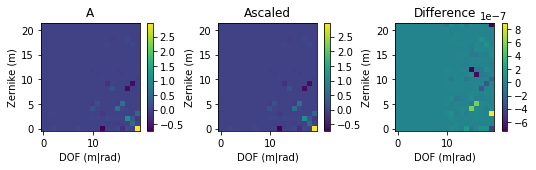

In [13]:
fig, axes = plt.subplots(1,3, figsize=(9,2))

for i, (title, matrix) in enumerate([('A', A), ('Ascaled', Ascaled), ('Difference', A-Ascaled)]):
    ax = axes[i]
    ax.set_title(title)
    im = ax.imshow(matrix, origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('DOF (m|rad)')
    ax.set_ylabel('Zernike (m)')

Furthermore, we compared a few specific sensitivity matrix elements to those from previous calculations and found them to agree to at least 3 significant figures. We end by plotting the log normalized absolute value of the sensitivity matrix. We see that there is a lot of degeneracy between the camera and M2 hexapod translations and rotations. We also see that M1M3 bending modes have a much broader zernike impact than M2 bending modes (columns 10-14 vs 15-19 in the plots below). M1M3 bending modes introduce perturbations to 2 surfaces in the optical path, as opposed to one, so this pattern makes sense.

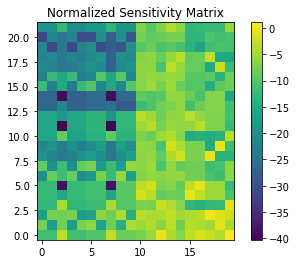

In [14]:
plt.title('Normalized Sensitivity Matrix')
plt.imshow(np.log(np.abs(A)), origin='lower')
plt.colorbar()

In [15]:
np.save('../data/nominal_wavefront_20dof', np.array(y0))
np.save('../data/sensitivity_matrix_20dof', A)

In [16]:
! ls ../data

M1M3_bending_modes.npy       M2_grid_x.npy
M1M3_grid_x.npy              M2_grid_y.npy
M1M3_grid_y.npy              nominal_wavefront_20dof.npy
M2_bending_modes.npy         sensitivity_matrix_20dof.npy
